[ 8  4  5  3  6  7  9  1 10  0]
[ 3.927723  -2.5837488 -2.63658   -2.867704  -3.0803578 -3.5267253
 -3.9674695 -4.186572  -4.2031956 -4.491361 ]
[8]
Test Predictions: 포카리스웨트 620ml


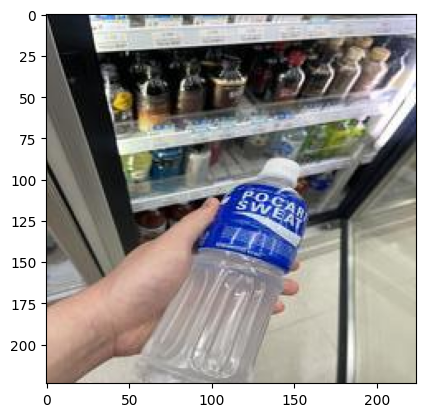

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
import timm
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "4"

class CustomImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomImageClassifier, self).__init__()
        self.base_model = timm.create_model('resnet50.a1_in1k', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        x = self.base_model(x)
        return x

def get_product_name(class_id, csv_path='path_to_csv_file.csv'):
    df = pd.read_csv(csv_path)
    class_to_name = df.set_index('class')['img_prod_nm'].to_dict()
    return class_to_name.get(class_id, "Unknown Product")

# 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 모델 로드 함수
def load_model(model_path, model, device='cuda'):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

# 추론 함수
def inference(model, image, device='cuda'):
    model.eval()
    with torch.no_grad():
        image = image.to(device).unsqueeze(0)  # 배치를 추가하기 위해 unsqueeze(0)을 사용
        outputs = model(image)
        logits = outputs.cpu().numpy()
        top10_indices = np.argsort(logits[0])[::-1][:10]
        print(top10_indices)
        print(logits[0][top10_indices])
        _, preds = torch.max(outputs, 1)
    return preds.cpu().numpy()

# 모델 경로 및 이미지 경로
# best_model_path = '/home/mmc/disk2/duck/cap/cnn/noodle_pt/model_epoch_50_loss_0.0074.pt'
# best_model_path = '/home/mmc/disk2/duck/cap/cnn/drink_pt_0518_resnet18/best.pt'
best_model_path = '/home/mmc/disk2/duck/cap/cnn/drink_pt_0520_resnet18/best_224_notseg.pt'

image_path = "/home/mmc/disk2/duck/cap/cnn/drink_2/images_224/val/0011.jpg"

# csv_path = '/home/mmc/disk2/duck/cap/data/csv/train/noodle.csv'
# csv_path = '/home/mmc/disk2/duck/cap/data/csv/train/drink.csv'
csv_path = '/home/mmc/disk2/duck/cap/cnn/drink_2/images_224/train/drink.csv'

num_classes = 11  # drink 1044 noodle 205 snack 1637

# 이미지 로드 및 변환
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
image = transform(image)

# 모델 정의 및 로드
model = CustomImageClassifier(num_classes=num_classes)
model = load_model(best_model_path, model, device='cuda')

# 추론 수행
test_predictions = inference(model, image, device='cuda')
result = get_product_name(test_predictions[0], csv_path)
print(test_predictions)
print(f'Test Predictions: {result}')
